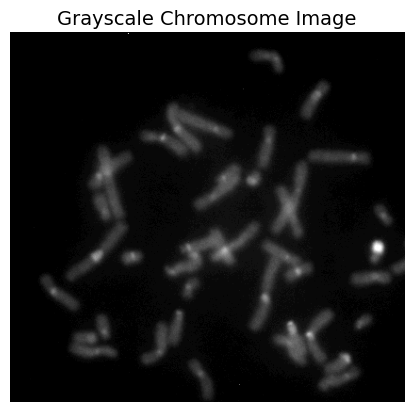

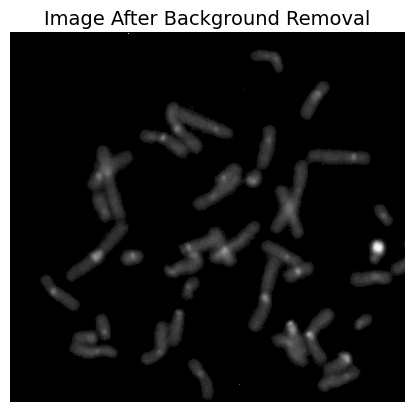

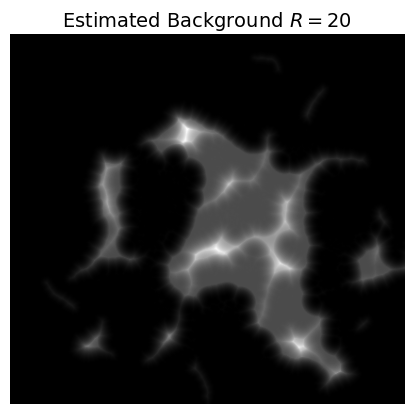

In [2]:
from skimage import restoration
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

def clean_background3():
    global workimage, ProgParams, imgObjs

    # Convert to NumPy array
    workimage = np.array(workimage)

    # Check the number of dimensions
    if len(workimage.shape) == 2:  # If the image is grayscale, add a third dimension
        workimage = np.expand_dims(workimage, axis=2)

    a, b, d3 = workimage.shape

    if d3 == 3:
        grayimage = cv2.cvtColor(workimage, cv2.COLOR_RGB2GRAY)
    else:
        # Extract the single channel from the grayscale image
        grayimage = workimage[:, :, 0].copy()

        # Expand the dimensions to (height, width, 3)
        workimage = np.zeros((a, b, 3), dtype=np.uint8)
        workimage[:, :, 0] = grayimage
        workimage[:, :, 1] = grayimage
        workimage[:, :, 2] = grayimage

    grayimage = grayimage.astype(np.float64)
    M_1 = np.max(np.max(grayimage))
    mult = 255 / M_1
    grayimage = grayimage * mult
    test = restoration.rolling_ball(grayimage, radius=20)
    noBG = grayimage - test
    noBG[noBG < 20] = 0

    return grayimage, noBG,test

# image_path = '2.tif'
image_path='C_11.tif'

workimage = Image.open(image_path)

grayimage, noBG,test= clean_background3()
# plt.figure(figsize=(6,6))
plt.imshow(grayimage,cmap="gray")
plt.title("Grayscale Chromosome Image",fontsize=14)
plt.axis("off")
plt.show()

# plt.figure(figsize=(6,6))
plt.title("Image After Background Removal",fontsize=14)
plt.imshow(noBG,cmap="gray")
plt.axis("off")
plt.show()

# plt.figure(figsize=(6,6))
plt.title(r"Estimated Background $R=20$",fontsize=14)
plt.imshow(test,cmap="gray")
plt.axis("off")
plt.show()

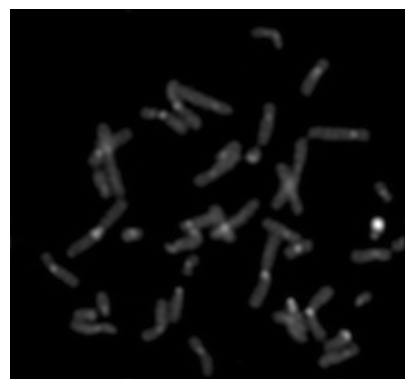

In [3]:

def Low_Pass_Filter():
    global noBG
    # Apply Fourier Transform
    F = np.fft.fft2(noBG)
    Fshift = np.fft.fftshift(F)

    # Low-pass filter
    M, N = noBG.shape
    H = np.zeros((M, N), dtype=np.float64)
    D0 = 50
    for u in range(M):
        for v in range(N):
            D = np.sqrt((u - M / 2) ** 2 + (v - N / 2) ** 2)
            if D <= D0:
                H[u, v] = 1
            else:
                H[u, v] = 0

    # Apply the filter in frequency domain
    Gshift = Fshift * H

    # Inverse Fourier Transform
    G = np.fft.ifftshift(Gshift)
    g = np.abs(np.fft.ifft2(G))
    # Display the filtered image
    plt.imshow(g, cmap='gray')
    # plt.title(r'Filtered Image ($D_0=50$)', fontsize=14)  
    plt.axis('off')
    plt.show()

    return g


filtered_noBG = Low_Pass_Filter()

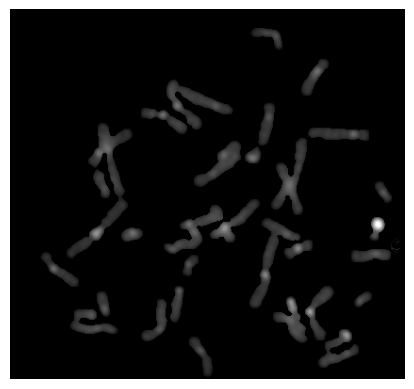

In [11]:
import matlab.engine
import numpy as np
import matplotlib.pyplot as plt

# Start MATLAB engine
eng = matlab.engine.start_matlab()

# Convert filtered_noBG to MATLAB format (double array)
filtered_noBG_matlab = matlab.double(filtered_noBG.tolist())

# Run MATLAB code on filtered_noBG
eng.workspace['img'] = filtered_noBG_matlab
eng.eval("run('C:\\Project pro 1\\code\\codeCheck.m')", nargout=0)

# Get the resulting images from MATLAB workspace
structimage = eng.workspace['structimage']
disfig=eng.workspace['dispfig']

# plt.imshow(np.array(disfig), cmap='gray')
# plt.axis("off")
# plt.show()
plt.imshow(structimage['image'], cmap='gray')
plt.axis("off")
plt.show()
# Stop MATLAB engine
eng.quit()
a=structimage['image']

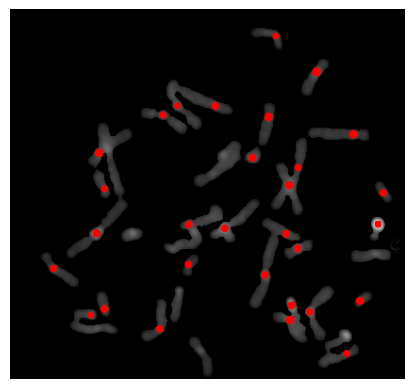

In [12]:
plt.imshow(np.array(disfig), cmap='gray')
plt.axis("off")
plt.show()